In [6]:
# Importing all necessary libraries
import os
import json
import sys

# Add root folder of the project in sys.path
module_path = os.path.abspath(os.path.join('..'))  # Up on one level higher 
if module_path not in sys.path:
    sys.path.append(module_path)

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import eXNN.topology

from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from plot_results import save_model_metrics_to_json

pd.set_option('display.max_columns', 50)

In [2]:
# Create a Full-Connected Neural Network class
# Model's hyperparameters were chosen by reading some papers about training MLP on MNIST
class MultiLayerPerceptron(nn.Module):
    def __init__(self, input_dim: int, output_dim: int) -> None:
        super(MultiLayerPerceptron, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

        self.layer2 = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

        self.layer3 = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

        self.layer4 = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

        self.layer5 = nn.Sequential(
            nn.Linear(512, output_dim),
        )

    # Define forward loop for NN
    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        return x

In [3]:
def train_and_eval_model(model, criterion, optimizer, train_loader, test_loader, epochs: int, batch: int, out_dir: str, test_data) -> tuple:
    ''' 
    Method performs training, evaluation and getting barcodes from MLP model with MNIST dataset
    Params:
    model - model to train;
    criterion - way to measure loss function;
    optimizer - method to perform gradient descent;
    train_loader - DataLoader with train data;
    test_loader - DataLoader with test data;
    epochs - number of epochs for train;
    batch - batch size;
    out_dir - folder for storing output data;
    test_data - Dataset with test data.
    Output:
    fig - figure with train and test losses;
    model_weights - dict with model weights.
    '''
    home_dir = f'./mnist_output/{out_dir}/weights_graphs_mlp_DataAmount{batch}/barcodes/'
    os.makedirs(home_dir)
    bar_datum = dict()
    bar_evaluation = dict()

    # Initialize tracker for minimum validation loss
    valid_loss_min = np.Inf  # Set initial "min" to infinity

    train_losses = list()
    test_losses = list()

    for epoch in range(epochs):

        layer_list = ['layer1', 'layer2', 'layer3', 'layer4', 'layer5']
        barcodes_data = dict()
        barcodes_eval = dict()
        if epoch == 0 and batch == 1000:
            barc_data = dict()
            barc_eval = dict()
            model_start_weights = model.state_dict()
            # Saving model's start weights
            epoch_dir = f'./mnist_output/{out_dir}/weights_graphs_mlp_DataAmount0/'
            os.makedirs(epoch_dir, exist_ok=True)
            torch.save(model_start_weights, f'./mnist_output/{out_dir}/weights_graphs_mlp_DataAmount0/weights_mlp_DataAmount0.pth')

            # Obtain barcodes from untrained network
            barcodes = eXNN.topology.get_nn_barcodes(model, data=torch.stack([test_data[i][0] for i in range(100)]), layers=layer_list, hom_type="standard", coefficient_type="2") #, coefs_type="2")
            epoch_dir = f'./mnist_output/{out_dir}/weights_graphs_mlp_DataAmount0/barcodes/'
            os.makedirs(epoch_dir, exist_ok=True)
            zero_barc_data = dict()
            zero_barc_eval = dict()
            for i in range(1, 6):
                barcode = barcodes[f'layer{i}']
                # Save barcodes' info into the JSON
                zero_barc_data.setdefault(f'layer{i}', barcode)

                # Obtain the barcode after epoch and saving it
                bplot = eXNN.topology.plot_barcode(barcode)
                save_fig_path = epoch_dir + f'layer{i}_barcode.png'
                bplot.savefig(save_fig_path)

                # Get and save evaluation for barcode into the JSON
                bar_eval = eXNN.topology.evaluate_barcode(barcode)
                zero_barc_eval.setdefault(f'layer{i}', bar_eval)

            barc_data.setdefault(f'epoch{epoch}', zero_barc_data)
            barc_eval.setdefault(f'epoch{epoch}', zero_barc_eval)

            with open(f'{epoch_dir}/barcode_data.json', 'w') as zero_data:
                json.dump(barc_data, zero_data, indent=4)

            with open(f'{epoch_dir}/barcode_eval.json', 'w') as zero_data:
                json.dump(barc_eval, zero_data, indent=4)

        # Monitor training loss
        train_loss = 0.0
        valid_loss = 0.0

        # Train the model
        model.train()  # Prep model for training
        for data, target in train_loader:
            # Clear the gradients of all optimized variables
            optimizer.zero_grad()
            # Forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # Calculate the loss
            loss = criterion(output, target)
            # Backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # Perform a single optimization step (parameter update)
            optimizer.step()
            # Update running training loss
            train_loss += loss.item()

        # Validate the model
        model.eval()  # Prep model for evaluation
        for data, target in test_loader:
            # Forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # Calculate the loss
            loss = criterion(output, target)
            # Update running validation loss
            valid_loss += loss.item()

        # Applying some TDA methods to study the obtained network
        model = model.to(torch.device('cpu'))
        data = torch.stack([test_data[i][0] for i in range(100)])
        barcodes = eXNN.topology.get_nn_barcodes(model, data, layers=layer_list, hom_type="standard", coefficient_type="2") #, coefs_type="2")
        epoch_dir = home_dir + f'epoch{epoch+1}/'
        os.makedirs(epoch_dir, exist_ok=True)
        for i in range(1, 6):
            barcode = barcodes[f'layer{i}']
            # Save barcodes' info into the JSON
            barcodes_data.setdefault(f'layer{i}', barcode)

            # Obtain the barcode after epoch and saving it
            bplot = eXNN.topology.plot_barcode(barcode)
            save_fig_path = epoch_dir + f'layer{i}_barcode.png'
            bplot.savefig(save_fig_path)

            # Get and save evaluation for barcode into the JSON
            bar_eval = eXNN.topology.evaluate_barcode(barcode)
            barcodes_eval.setdefault(f'layer{i}', bar_eval)

        bar_datum.setdefault(f'epoch{epoch+1}', barcodes_data)
        bar_evaluation.setdefault(f'epoch{epoch+1}', barcodes_eval)

        # Print training/validation statistics
        # Calculate average loss over an epoch
        train_loss = train_loss / len(train_loader)
        valid_loss = valid_loss / len(test_loader)
        train_losses.append(train_loss)
        test_losses.append(valid_loss)

        # Print training and validation loss for the current epoch
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch + 1,  # Epoch number (starting from 1)
            train_loss,  # Average training loss for the epoch
            valid_loss  # Average validation loss for the epoch
        ))

        # Save the model if the validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                valid_loss_min,  # Previous minimum validation loss
                valid_loss  # Current validation loss
            ))
            torch.save(model.state_dict(), './best_mlp_mnist_5layers.pt')  # Save the model's state dictionary
            valid_loss_min = valid_loss  # Update the minimum validation loss

    # Save dictionaries with barcodes' data and evaluation as JSON files
    with open(f'{home_dir}barcode_data.json', 'w', encoding='utf-8') as file:
        json.dump(bar_datum, file, indent=4)
    
    with open(f'{home_dir}barcode_evaluation.json', 'w', encoding='utf-8') as json_eval:
        json.dump(bar_evaluation, json_eval, indent=4)

    # Get model's weights
    model_weights = model.state_dict()

    # Loss and MAPE visualisation
    fig = plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.title('Losses over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Metric')
    plt.legend()
    plt.grid(True)
    plt.show()

    return fig, model_weights

In [4]:
def batch_training(batch_size: int, out_folder: str) -> tuple:
    ''' 
    This method performs training model with set batches of data
    Params:
    batch_size - size of the batch;
    out_folder - folder to store the output data.
    Output:
    fig - figure with train and test losses;
    model_weights - dict with model's weights
    '''
    # Define parameters
    BATCH_SIZE = 4

    # Convert images to tensors
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize( (0.1307, ), (0.3081, ))])

    # Load datasets
    train_set = datasets.MNIST(root='data', train=True, download=True, transform=transform)
    test_set = datasets.MNIST(root='data', train=False, download=True, transform=transform)

    # Split train and test datasets into batches
    train_subset = Subset(train_set, indices=list(range(batch_size)))
    test_subset = Subset(test_set, indices=list(range(round((batch_size*len(test_set))/len(train_set)))))

    # Create DataLoaders
    train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_subset, batch_size=BATCH_SIZE, shuffle=False)

    # Model initialization
    model = MultiLayerPerceptron(28*28, 10)

    # Define optimizator and loss function
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-05)

    fig, model_weights = train_and_eval_model(model=model, criterion=criterion, optimizer=optimizer, train_loader=train_loader,
                                              test_loader=test_loader, epochs=50, batch=batch_size, out_dir=out_folder, test_data=test_set)
    
    return fig, model_weights

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ut

Epoch: 1 	Training Loss: 2.298311 	Validation Loss: 2.291528
Validation loss decreased (inf --> 2.291528).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 2 	Training Loss: 2.275327 	Validation Loss: 2.260074
Validation loss decreased (2.291528 --> 2.260074).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 3 	Training Loss: 2.219554 	Validation Loss: 2.167764
Validation loss decreased (2.260074 --> 2.167764).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 4 	Training Loss: 2.052232 	Validation Loss: 1.886341
Validation loss decreased (2.167764 --> 1.886341).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 5 	Training Loss: 1.692615 	Validation Loss: 1.448411
Validation loss decreased (1.886341 --> 1.448411).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 6 	Training Loss: 1.313970 	Validation Loss: 1.135676
Validation loss decreased (1.448411 --> 1.135676).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 7 	Training Loss: 1.063753 	Validation Loss: 0.951134
Validation loss decreased (1.135676 --> 0.951134).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 8 	Training Loss: 0.906353 	Validation Loss: 0.820449
Validation loss decreased (0.951134 --> 0.820449).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 9 	Training Loss: 0.809941 	Validation Loss: 0.749877
Validation loss decreased (0.820449 --> 0.749877).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 10 	Training Loss: 0.717890 	Validation Loss: 0.686638
Validation loss decreased (0.749877 --> 0.686638).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 11 	Training Loss: 0.669381 	Validation Loss: 0.630976
Validation loss decreased (0.686638 --> 0.630976).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 12 	Training Loss: 0.611764 	Validation Loss: 0.590901
Validation loss decreased (0.630976 --> 0.590901).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 13 	Training Loss: 0.578879 	Validation Loss: 0.569212
Validation loss decreased (0.590901 --> 0.569212).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 14 	Training Loss: 0.533509 	Validation Loss: 0.552853
Validation loss decreased (0.569212 --> 0.552853).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 15 	Training Loss: 0.495984 	Validation Loss: 0.535600
Validation loss decreased (0.552853 --> 0.535600).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 16 	Training Loss: 0.484696 	Validation Loss: 0.522000
Validation loss decreased (0.535600 --> 0.522000).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 17 	Training Loss: 0.457058 	Validation Loss: 0.508058
Validation loss decreased (0.522000 --> 0.508058).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 18 	Training Loss: 0.435227 	Validation Loss: 0.475211
Validation loss decreased (0.508058 --> 0.475211).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 19 	Training Loss: 0.419330 	Validation Loss: 0.466346
Validation loss decreased (0.475211 --> 0.466346).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 20 	Training Loss: 0.387418 	Validation Loss: 0.460282
Validation loss decreased (0.466346 --> 0.460282).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 21 	Training Loss: 0.383038 	Validation Loss: 0.440016
Validation loss decreased (0.460282 --> 0.440016).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 22 	Training Loss: 0.369741 	Validation Loss: 0.431202
Validation loss decreased (0.440016 --> 0.431202).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 23 	Training Loss: 0.347180 	Validation Loss: 0.419907
Validation loss decreased (0.431202 --> 0.419907).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 24 	Training Loss: 0.338259 	Validation Loss: 0.420125


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 25 	Training Loss: 0.339534 	Validation Loss: 0.408506
Validation loss decreased (0.419907 --> 0.408506).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 26 	Training Loss: 0.305873 	Validation Loss: 0.423539


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 27 	Training Loss: 0.311548 	Validation Loss: 0.394619
Validation loss decreased (0.408506 --> 0.394619).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 28 	Training Loss: 0.283791 	Validation Loss: 0.396942


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 29 	Training Loss: 0.270523 	Validation Loss: 0.393982
Validation loss decreased (0.394619 --> 0.393982).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 30 	Training Loss: 0.268602 	Validation Loss: 0.382591
Validation loss decreased (0.393982 --> 0.382591).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 31 	Training Loss: 0.262194 	Validation Loss: 0.381989
Validation loss decreased (0.382591 --> 0.381989).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 32 	Training Loss: 0.254344 	Validation Loss: 0.378431
Validation loss decreased (0.381989 --> 0.378431).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 33 	Training Loss: 0.252979 	Validation Loss: 0.366058
Validation loss decreased (0.378431 --> 0.366058).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 34 	Training Loss: 0.225930 	Validation Loss: 0.372587


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 35 	Training Loss: 0.225275 	Validation Loss: 0.360993
Validation loss decreased (0.366058 --> 0.360993).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 36 	Training Loss: 0.219360 	Validation Loss: 0.356232
Validation loss decreased (0.360993 --> 0.356232).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 37 	Training Loss: 0.212536 	Validation Loss: 0.351923
Validation loss decreased (0.356232 --> 0.351923).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 38 	Training Loss: 0.205189 	Validation Loss: 0.342090
Validation loss decreased (0.351923 --> 0.342090).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 39 	Training Loss: 0.198012 	Validation Loss: 0.342667


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 40 	Training Loss: 0.187075 	Validation Loss: 0.352917


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 41 	Training Loss: 0.180278 	Validation Loss: 0.346048


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 42 	Training Loss: 0.182730 	Validation Loss: 0.337034
Validation loss decreased (0.342090 --> 0.337034).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 43 	Training Loss: 0.173718 	Validation Loss: 0.332414
Validation loss decreased (0.337034 --> 0.332414).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 44 	Training Loss: 0.161694 	Validation Loss: 0.337119


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 45 	Training Loss: 0.144398 	Validation Loss: 0.343364


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 46 	Training Loss: 0.159908 	Validation Loss: 0.336907


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 47 	Training Loss: 0.143131 	Validation Loss: 0.333163


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 48 	Training Loss: 0.141103 	Validation Loss: 0.333749


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 49 	Training Loss: 0.125241 	Validation Loss: 0.331139
Validation loss decreased (0.332414 --> 0.331139).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 50 	Training Loss: 0.131328 	Validation Loss: 0.336969


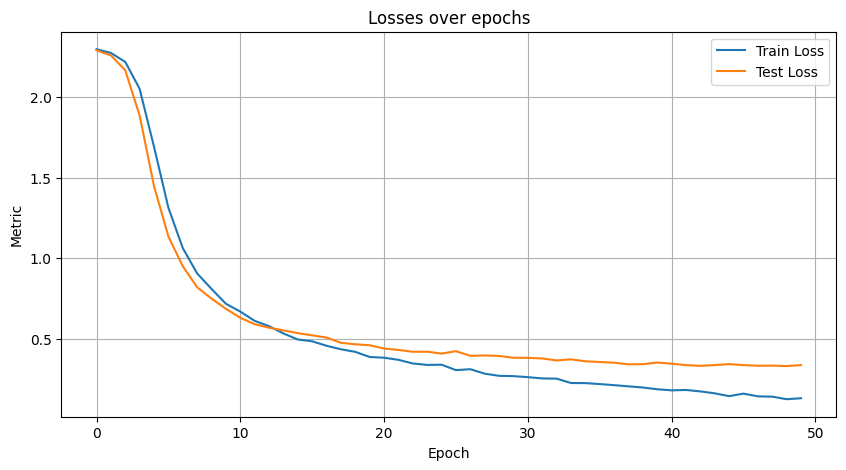

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 1 	Training Loss: 2.284675 	Validation Loss: 2.254810
Validation loss decreased (inf --> 2.254810).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 2 	Training Loss: 2.141430 	Validation Loss: 1.919351
Validation loss decreased (2.254810 --> 1.919351).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 3 	Training Loss: 1.556720 	Validation Loss: 1.213517
Validation loss decreased (1.919351 --> 1.213517).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 4 	Training Loss: 1.029450 	Validation Loss: 0.901312
Validation loss decreased (1.213517 --> 0.901312).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 5 	Training Loss: 0.817049 	Validation Loss: 0.738626
Validation loss decreased (0.901312 --> 0.738626).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 6 	Training Loss: 0.701769 	Validation Loss: 0.652179
Validation loss decreased (0.738626 --> 0.652179).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 7 	Training Loss: 0.603967 	Validation Loss: 0.585216
Validation loss decreased (0.652179 --> 0.585216).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 8 	Training Loss: 0.541578 	Validation Loss: 0.529749
Validation loss decreased (0.585216 --> 0.529749).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 9 	Training Loss: 0.495844 	Validation Loss: 0.495247
Validation loss decreased (0.529749 --> 0.495247).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 10 	Training Loss: 0.464500 	Validation Loss: 0.471959
Validation loss decreased (0.495247 --> 0.471959).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 11 	Training Loss: 0.431758 	Validation Loss: 0.454657
Validation loss decreased (0.471959 --> 0.454657).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 12 	Training Loss: 0.395501 	Validation Loss: 0.426026
Validation loss decreased (0.454657 --> 0.426026).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 13 	Training Loss: 0.393178 	Validation Loss: 0.412613
Validation loss decreased (0.426026 --> 0.412613).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 14 	Training Loss: 0.376671 	Validation Loss: 0.395385
Validation loss decreased (0.412613 --> 0.395385).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 15 	Training Loss: 0.356926 	Validation Loss: 0.391632
Validation loss decreased (0.395385 --> 0.391632).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 16 	Training Loss: 0.340593 	Validation Loss: 0.365576
Validation loss decreased (0.391632 --> 0.365576).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 17 	Training Loss: 0.321218 	Validation Loss: 0.357485
Validation loss decreased (0.365576 --> 0.357485).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 18 	Training Loss: 0.303254 	Validation Loss: 0.349147
Validation loss decreased (0.357485 --> 0.349147).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 19 	Training Loss: 0.303115 	Validation Loss: 0.348844
Validation loss decreased (0.349147 --> 0.348844).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 20 	Training Loss: 0.290625 	Validation Loss: 0.336132
Validation loss decreased (0.348844 --> 0.336132).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 21 	Training Loss: 0.271470 	Validation Loss: 0.335657
Validation loss decreased (0.336132 --> 0.335657).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 22 	Training Loss: 0.254833 	Validation Loss: 0.325526
Validation loss decreased (0.335657 --> 0.325526).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 23 	Training Loss: 0.256840 	Validation Loss: 0.323492
Validation loss decreased (0.325526 --> 0.323492).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 24 	Training Loss: 0.245587 	Validation Loss: 0.320739
Validation loss decreased (0.323492 --> 0.320739).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 25 	Training Loss: 0.240952 	Validation Loss: 0.313875
Validation loss decreased (0.320739 --> 0.313875).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 26 	Training Loss: 0.231179 	Validation Loss: 0.306257
Validation loss decreased (0.313875 --> 0.306257).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 27 	Training Loss: 0.228572 	Validation Loss: 0.302398
Validation loss decreased (0.306257 --> 0.302398).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 28 	Training Loss: 0.211425 	Validation Loss: 0.298349
Validation loss decreased (0.302398 --> 0.298349).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 29 	Training Loss: 0.202385 	Validation Loss: 0.306829


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 30 	Training Loss: 0.204637 	Validation Loss: 0.297167
Validation loss decreased (0.298349 --> 0.297167).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 31 	Training Loss: 0.196138 	Validation Loss: 0.286182
Validation loss decreased (0.297167 --> 0.286182).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 32 	Training Loss: 0.189317 	Validation Loss: 0.285318
Validation loss decreased (0.286182 --> 0.285318).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 33 	Training Loss: 0.176659 	Validation Loss: 0.292976


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 34 	Training Loss: 0.168957 	Validation Loss: 0.287140


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 35 	Training Loss: 0.172495 	Validation Loss: 0.281450
Validation loss decreased (0.285318 --> 0.281450).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 36 	Training Loss: 0.152168 	Validation Loss: 0.298211


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 37 	Training Loss: 0.161762 	Validation Loss: 0.278388
Validation loss decreased (0.281450 --> 0.278388).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 38 	Training Loss: 0.149719 	Validation Loss: 0.288182


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 39 	Training Loss: 0.140821 	Validation Loss: 0.280213


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 40 	Training Loss: 0.138837 	Validation Loss: 0.274557
Validation loss decreased (0.278388 --> 0.274557).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 41 	Training Loss: 0.129091 	Validation Loss: 0.278741


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 42 	Training Loss: 0.125088 	Validation Loss: 0.275573


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 43 	Training Loss: 0.116555 	Validation Loss: 0.272829
Validation loss decreased (0.274557 --> 0.272829).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 44 	Training Loss: 0.117519 	Validation Loss: 0.274510


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 45 	Training Loss: 0.110959 	Validation Loss: 0.267907
Validation loss decreased (0.272829 --> 0.267907).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 46 	Training Loss: 0.101364 	Validation Loss: 0.282411


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 47 	Training Loss: 0.102363 	Validation Loss: 0.269661


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 48 	Training Loss: 0.091405 	Validation Loss: 0.275675


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 49 	Training Loss: 0.089976 	Validation Loss: 0.278697


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 50 	Training Loss: 0.086605 	Validation Loss: 0.276712


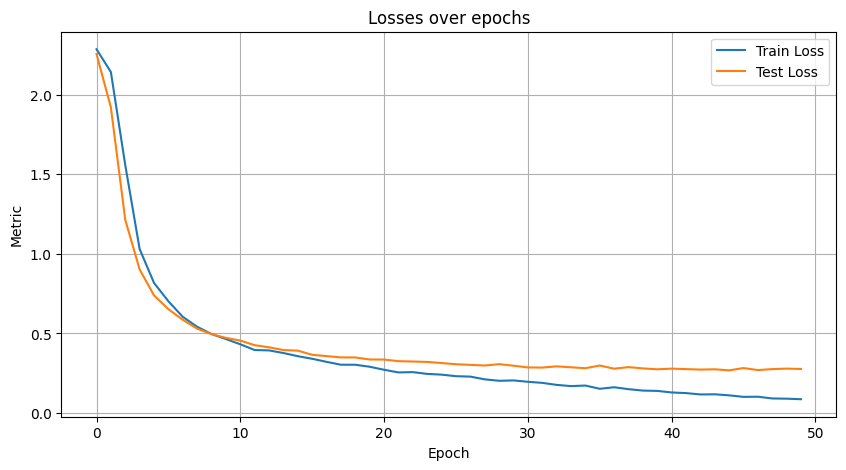

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 1 	Training Loss: 2.261345 	Validation Loss: 2.156551
Validation loss decreased (inf --> 2.156551).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 2 	Training Loss: 1.671472 	Validation Loss: 1.162260
Validation loss decreased (2.156551 --> 1.162260).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 3 	Training Loss: 0.946384 	Validation Loss: 0.797334
Validation loss decreased (1.162260 --> 0.797334).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 4 	Training Loss: 0.718995 	Validation Loss: 0.653327
Validation loss decreased (0.797334 --> 0.653327).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 5 	Training Loss: 0.609149 	Validation Loss: 0.570563
Validation loss decreased (0.653327 --> 0.570563).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 6 	Training Loss: 0.538681 	Validation Loss: 0.514123
Validation loss decreased (0.570563 --> 0.514123).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 7 	Training Loss: 0.484501 	Validation Loss: 0.475488
Validation loss decreased (0.514123 --> 0.475488).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 8 	Training Loss: 0.445308 	Validation Loss: 0.464918
Validation loss decreased (0.475488 --> 0.464918).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 9 	Training Loss: 0.419536 	Validation Loss: 0.423008
Validation loss decreased (0.464918 --> 0.423008).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 10 	Training Loss: 0.383582 	Validation Loss: 0.397122
Validation loss decreased (0.423008 --> 0.397122).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 11 	Training Loss: 0.367175 	Validation Loss: 0.380379
Validation loss decreased (0.397122 --> 0.380379).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 12 	Training Loss: 0.353014 	Validation Loss: 0.364868
Validation loss decreased (0.380379 --> 0.364868).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 13 	Training Loss: 0.333020 	Validation Loss: 0.361809
Validation loss decreased (0.364868 --> 0.361809).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 14 	Training Loss: 0.318401 	Validation Loss: 0.351923
Validation loss decreased (0.361809 --> 0.351923).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 15 	Training Loss: 0.300857 	Validation Loss: 0.343161
Validation loss decreased (0.351923 --> 0.343161).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 16 	Training Loss: 0.281231 	Validation Loss: 0.329560
Validation loss decreased (0.343161 --> 0.329560).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 17 	Training Loss: 0.275915 	Validation Loss: 0.315970
Validation loss decreased (0.329560 --> 0.315970).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 18 	Training Loss: 0.258121 	Validation Loss: 0.307486
Validation loss decreased (0.315970 --> 0.307486).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 19 	Training Loss: 0.244725 	Validation Loss: 0.304463
Validation loss decreased (0.307486 --> 0.304463).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 20 	Training Loss: 0.233741 	Validation Loss: 0.295253
Validation loss decreased (0.304463 --> 0.295253).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 21 	Training Loss: 0.226278 	Validation Loss: 0.289600
Validation loss decreased (0.295253 --> 0.289600).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 22 	Training Loss: 0.217978 	Validation Loss: 0.293655


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 23 	Training Loss: 0.206650 	Validation Loss: 0.282327
Validation loss decreased (0.289600 --> 0.282327).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 24 	Training Loss: 0.203302 	Validation Loss: 0.279521
Validation loss decreased (0.282327 --> 0.279521).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 25 	Training Loss: 0.183603 	Validation Loss: 0.283089


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 26 	Training Loss: 0.182167 	Validation Loss: 0.282931


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 27 	Training Loss: 0.171754 	Validation Loss: 0.260031
Validation loss decreased (0.279521 --> 0.260031).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 28 	Training Loss: 0.163003 	Validation Loss: 0.260319


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 29 	Training Loss: 0.162540 	Validation Loss: 0.255580
Validation loss decreased (0.260031 --> 0.255580).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 30 	Training Loss: 0.148210 	Validation Loss: 0.247744
Validation loss decreased (0.255580 --> 0.247744).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 31 	Training Loss: 0.143848 	Validation Loss: 0.243389
Validation loss decreased (0.247744 --> 0.243389).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 32 	Training Loss: 0.136841 	Validation Loss: 0.250819


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 33 	Training Loss: 0.133933 	Validation Loss: 0.245443


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 34 	Training Loss: 0.122369 	Validation Loss: 0.247695


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 35 	Training Loss: 0.121707 	Validation Loss: 0.242782
Validation loss decreased (0.243389 --> 0.242782).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 36 	Training Loss: 0.106419 	Validation Loss: 0.245596


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 37 	Training Loss: 0.107383 	Validation Loss: 0.229988
Validation loss decreased (0.242782 --> 0.229988).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 38 	Training Loss: 0.102743 	Validation Loss: 0.227169
Validation loss decreased (0.229988 --> 0.227169).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 39 	Training Loss: 0.094303 	Validation Loss: 0.241302


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 40 	Training Loss: 0.093721 	Validation Loss: 0.229662


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 41 	Training Loss: 0.082067 	Validation Loss: 0.236351


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 42 	Training Loss: 0.081169 	Validation Loss: 0.232152


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 43 	Training Loss: 0.079787 	Validation Loss: 0.227961


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 44 	Training Loss: 0.070775 	Validation Loss: 0.233359


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 45 	Training Loss: 0.070598 	Validation Loss: 0.230839


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 46 	Training Loss: 0.065407 	Validation Loss: 0.227248


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 47 	Training Loss: 0.051825 	Validation Loss: 0.236861


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 48 	Training Loss: 0.055772 	Validation Loss: 0.233708


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 49 	Training Loss: 0.050777 	Validation Loss: 0.236369


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 50 	Training Loss: 0.052729 	Validation Loss: 0.233375


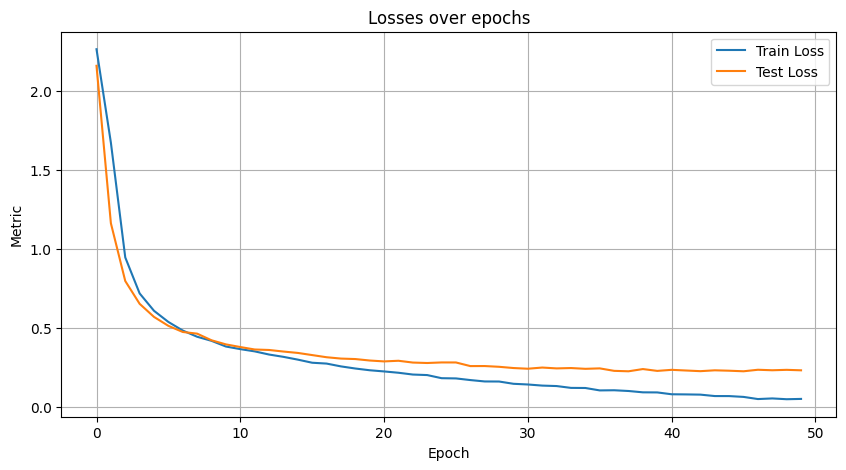

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 1 	Training Loss: 2.213584 	Validation Loss: 1.920354
Validation loss decreased (inf --> 1.920354).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 2 	Training Loss: 1.272887 	Validation Loss: 0.898511
Validation loss decreased (1.920354 --> 0.898511).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 3 	Training Loss: 0.744764 	Validation Loss: 0.673966
Validation loss decreased (0.898511 --> 0.673966).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 4 	Training Loss: 0.600914 	Validation Loss: 0.582692
Validation loss decreased (0.673966 --> 0.582692).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 5 	Training Loss: 0.501200 	Validation Loss: 0.512700
Validation loss decreased (0.582692 --> 0.512700).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 6 	Training Loss: 0.445762 	Validation Loss: 0.477870
Validation loss decreased (0.512700 --> 0.477870).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 7 	Training Loss: 0.411567 	Validation Loss: 0.444319
Validation loss decreased (0.477870 --> 0.444319).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 8 	Training Loss: 0.382976 	Validation Loss: 0.419607
Validation loss decreased (0.444319 --> 0.419607).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 9 	Training Loss: 0.358572 	Validation Loss: 0.402662
Validation loss decreased (0.419607 --> 0.402662).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 10 	Training Loss: 0.326267 	Validation Loss: 0.394378
Validation loss decreased (0.402662 --> 0.394378).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 11 	Training Loss: 0.319436 	Validation Loss: 0.369428
Validation loss decreased (0.394378 --> 0.369428).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 12 	Training Loss: 0.294596 	Validation Loss: 0.349078
Validation loss decreased (0.369428 --> 0.349078).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 13 	Training Loss: 0.283140 	Validation Loss: 0.340401
Validation loss decreased (0.349078 --> 0.340401).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 14 	Training Loss: 0.262555 	Validation Loss: 0.334964
Validation loss decreased (0.340401 --> 0.334964).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 15 	Training Loss: 0.248224 	Validation Loss: 0.328970
Validation loss decreased (0.334964 --> 0.328970).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 16 	Training Loss: 0.238142 	Validation Loss: 0.312383
Validation loss decreased (0.328970 --> 0.312383).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 17 	Training Loss: 0.221345 	Validation Loss: 0.302546
Validation loss decreased (0.312383 --> 0.302546).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 18 	Training Loss: 0.220303 	Validation Loss: 0.295299
Validation loss decreased (0.302546 --> 0.295299).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 19 	Training Loss: 0.204078 	Validation Loss: 0.292510
Validation loss decreased (0.295299 --> 0.292510).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 20 	Training Loss: 0.188575 	Validation Loss: 0.297832


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 21 	Training Loss: 0.182652 	Validation Loss: 0.274027
Validation loss decreased (0.292510 --> 0.274027).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 22 	Training Loss: 0.171806 	Validation Loss: 0.274501


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 23 	Training Loss: 0.168923 	Validation Loss: 0.269488
Validation loss decreased (0.274027 --> 0.269488).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 24 	Training Loss: 0.155110 	Validation Loss: 0.259758
Validation loss decreased (0.269488 --> 0.259758).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 25 	Training Loss: 0.144290 	Validation Loss: 0.260653


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 26 	Training Loss: 0.144444 	Validation Loss: 0.251484
Validation loss decreased (0.259758 --> 0.251484).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 27 	Training Loss: 0.131477 	Validation Loss: 0.264218


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 28 	Training Loss: 0.116639 	Validation Loss: 0.247050
Validation loss decreased (0.251484 --> 0.247050).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 29 	Training Loss: 0.116610 	Validation Loss: 0.244867
Validation loss decreased (0.247050 --> 0.244867).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 30 	Training Loss: 0.117798 	Validation Loss: 0.235614
Validation loss decreased (0.244867 --> 0.235614).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 31 	Training Loss: 0.104353 	Validation Loss: 0.234921
Validation loss decreased (0.235614 --> 0.234921).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 32 	Training Loss: 0.096110 	Validation Loss: 0.234950


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 33 	Training Loss: 0.092107 	Validation Loss: 0.240859


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 34 	Training Loss: 0.090309 	Validation Loss: 0.231964
Validation loss decreased (0.234921 --> 0.231964).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 35 	Training Loss: 0.082550 	Validation Loss: 0.223998
Validation loss decreased (0.231964 --> 0.223998).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 36 	Training Loss: 0.077713 	Validation Loss: 0.225937


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 37 	Training Loss: 0.077341 	Validation Loss: 0.225991


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 38 	Training Loss: 0.072220 	Validation Loss: 0.226815


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 39 	Training Loss: 0.064610 	Validation Loss: 0.233064


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 40 	Training Loss: 0.061810 	Validation Loss: 0.239233


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 41 	Training Loss: 0.059340 	Validation Loss: 0.239625


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 42 	Training Loss: 0.055147 	Validation Loss: 0.241526


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 43 	Training Loss: 0.049768 	Validation Loss: 0.237800


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 44 	Training Loss: 0.048072 	Validation Loss: 0.243807


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 45 	Training Loss: 0.043501 	Validation Loss: 0.233495


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 46 	Training Loss: 0.041074 	Validation Loss: 0.225449


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 47 	Training Loss: 0.037232 	Validation Loss: 0.231869


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 48 	Training Loss: 0.040669 	Validation Loss: 0.231110


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 49 	Training Loss: 0.034342 	Validation Loss: 0.231473


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 50 	Training Loss: 0.032180 	Validation Loss: 0.232053


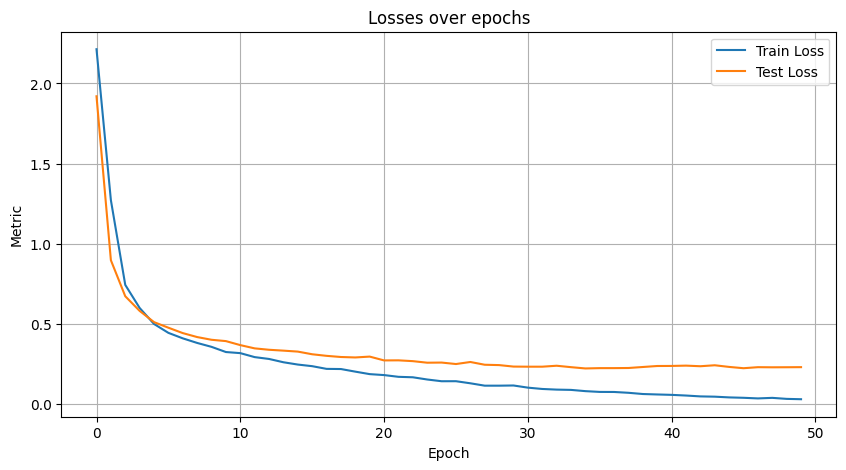

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 1 	Training Loss: 2.122396 	Validation Loss: 1.524664
Validation loss decreased (inf --> 1.524664).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 2 	Training Loss: 1.027773 	Validation Loss: 0.775778
Validation loss decreased (1.524664 --> 0.775778).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 3 	Training Loss: 0.672749 	Validation Loss: 0.595808
Validation loss decreased (0.775778 --> 0.595808).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 4 	Training Loss: 0.547555 	Validation Loss: 0.503133
Validation loss decreased (0.595808 --> 0.503133).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 5 	Training Loss: 0.473544 	Validation Loss: 0.458212
Validation loss decreased (0.503133 --> 0.458212).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 6 	Training Loss: 0.415446 	Validation Loss: 0.435574
Validation loss decreased (0.458212 --> 0.435574).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 7 	Training Loss: 0.383493 	Validation Loss: 0.398791
Validation loss decreased (0.435574 --> 0.398791).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 8 	Training Loss: 0.352402 	Validation Loss: 0.375010
Validation loss decreased (0.398791 --> 0.375010).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 9 	Training Loss: 0.330488 	Validation Loss: 0.369573
Validation loss decreased (0.375010 --> 0.369573).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 10 	Training Loss: 0.308227 	Validation Loss: 0.354486
Validation loss decreased (0.369573 --> 0.354486).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 11 	Training Loss: 0.289847 	Validation Loss: 0.333791
Validation loss decreased (0.354486 --> 0.333791).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 12 	Training Loss: 0.275877 	Validation Loss: 0.321452
Validation loss decreased (0.333791 --> 0.321452).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 13 	Training Loss: 0.255529 	Validation Loss: 0.311657
Validation loss decreased (0.321452 --> 0.311657).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 14 	Training Loss: 0.238202 	Validation Loss: 0.301497
Validation loss decreased (0.311657 --> 0.301497).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 15 	Training Loss: 0.229935 	Validation Loss: 0.290536
Validation loss decreased (0.301497 --> 0.290536).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 16 	Training Loss: 0.222381 	Validation Loss: 0.281865
Validation loss decreased (0.290536 --> 0.281865).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 17 	Training Loss: 0.208818 	Validation Loss: 0.276459
Validation loss decreased (0.281865 --> 0.276459).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 18 	Training Loss: 0.198197 	Validation Loss: 0.277235


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 19 	Training Loss: 0.184984 	Validation Loss: 0.270314
Validation loss decreased (0.276459 --> 0.270314).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 20 	Training Loss: 0.176948 	Validation Loss: 0.263795
Validation loss decreased (0.270314 --> 0.263795).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 21 	Training Loss: 0.168914 	Validation Loss: 0.258156
Validation loss decreased (0.263795 --> 0.258156).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 22 	Training Loss: 0.159981 	Validation Loss: 0.251590
Validation loss decreased (0.258156 --> 0.251590).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 23 	Training Loss: 0.152336 	Validation Loss: 0.249413
Validation loss decreased (0.251590 --> 0.249413).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 24 	Training Loss: 0.142078 	Validation Loss: 0.248096
Validation loss decreased (0.249413 --> 0.248096).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 25 	Training Loss: 0.137742 	Validation Loss: 0.240867
Validation loss decreased (0.248096 --> 0.240867).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 26 	Training Loss: 0.129300 	Validation Loss: 0.245245


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 27 	Training Loss: 0.124997 	Validation Loss: 0.241783


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 28 	Training Loss: 0.117594 	Validation Loss: 0.232225
Validation loss decreased (0.240867 --> 0.232225).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 29 	Training Loss: 0.104701 	Validation Loss: 0.237097


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 30 	Training Loss: 0.097475 	Validation Loss: 0.236034


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 31 	Training Loss: 0.097570 	Validation Loss: 0.231454
Validation loss decreased (0.232225 --> 0.231454).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 32 	Training Loss: 0.086589 	Validation Loss: 0.233236


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 33 	Training Loss: 0.081180 	Validation Loss: 0.234500


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 34 	Training Loss: 0.077411 	Validation Loss: 0.228555
Validation loss decreased (0.231454 --> 0.228555).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 35 	Training Loss: 0.075311 	Validation Loss: 0.226891
Validation loss decreased (0.228555 --> 0.226891).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 36 	Training Loss: 0.069329 	Validation Loss: 0.221814
Validation loss decreased (0.226891 --> 0.221814).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 37 	Training Loss: 0.066080 	Validation Loss: 0.227200


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 38 	Training Loss: 0.060561 	Validation Loss: 0.224031


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 39 	Training Loss: 0.059239 	Validation Loss: 0.225176


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 40 	Training Loss: 0.054690 	Validation Loss: 0.229279


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 41 	Training Loss: 0.052196 	Validation Loss: 0.226005


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 42 	Training Loss: 0.048029 	Validation Loss: 0.224587


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 43 	Training Loss: 0.046169 	Validation Loss: 0.228557


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 44 	Training Loss: 0.042734 	Validation Loss: 0.233141


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 45 	Training Loss: 0.040486 	Validation Loss: 0.226629


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 46 	Training Loss: 0.040701 	Validation Loss: 0.230405


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 47 	Training Loss: 0.035103 	Validation Loss: 0.244679


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 48 	Training Loss: 0.034988 	Validation Loss: 0.240538


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 49 	Training Loss: 0.032604 	Validation Loss: 0.236725


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 50 	Training Loss: 0.029194 	Validation Loss: 0.249365


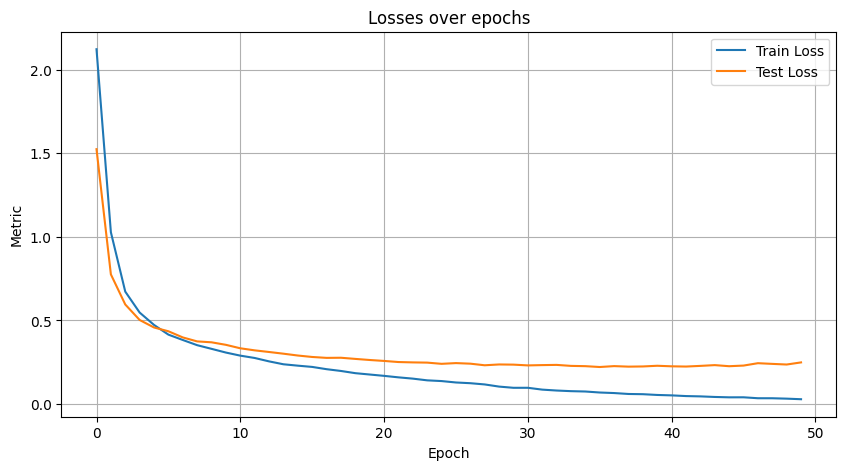

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 1 	Training Loss: 1.566047 	Validation Loss: 0.769129
Validation loss decreased (inf --> 0.769129).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 2 	Training Loss: 0.608200 	Validation Loss: 0.528728
Validation loss decreased (0.769129 --> 0.528728).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 3 	Training Loss: 0.454407 	Validation Loss: 0.449324
Validation loss decreased (0.528728 --> 0.449324).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 4 	Training Loss: 0.389929 	Validation Loss: 0.403101
Validation loss decreased (0.449324 --> 0.403101).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 5 	Training Loss: 0.343300 	Validation Loss: 0.379784
Validation loss decreased (0.403101 --> 0.379784).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 6 	Training Loss: 0.315128 	Validation Loss: 0.350888
Validation loss decreased (0.379784 --> 0.350888).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 7 	Training Loss: 0.287025 	Validation Loss: 0.327308
Validation loss decreased (0.350888 --> 0.327308).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 8 	Training Loss: 0.260513 	Validation Loss: 0.307981
Validation loss decreased (0.327308 --> 0.307981).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 9 	Training Loss: 0.240174 	Validation Loss: 0.302493
Validation loss decreased (0.307981 --> 0.302493).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 10 	Training Loss: 0.223151 	Validation Loss: 0.283303
Validation loss decreased (0.302493 --> 0.283303).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 11 	Training Loss: 0.208717 	Validation Loss: 0.274002
Validation loss decreased (0.283303 --> 0.274002).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 12 	Training Loss: 0.191651 	Validation Loss: 0.276554


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 13 	Training Loss: 0.179955 	Validation Loss: 0.255436
Validation loss decreased (0.274002 --> 0.255436).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 14 	Training Loss: 0.164669 	Validation Loss: 0.251089
Validation loss decreased (0.255436 --> 0.251089).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 15 	Training Loss: 0.156441 	Validation Loss: 0.242260
Validation loss decreased (0.251089 --> 0.242260).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 16 	Training Loss: 0.144720 	Validation Loss: 0.245423


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 17 	Training Loss: 0.134438 	Validation Loss: 0.242002
Validation loss decreased (0.242260 --> 0.242002).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 18 	Training Loss: 0.125955 	Validation Loss: 0.227818
Validation loss decreased (0.242002 --> 0.227818).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 19 	Training Loss: 0.121728 	Validation Loss: 0.223315
Validation loss decreased (0.227818 --> 0.223315).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 20 	Training Loss: 0.105538 	Validation Loss: 0.225626


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 21 	Training Loss: 0.102166 	Validation Loss: 0.219558
Validation loss decreased (0.223315 --> 0.219558).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 22 	Training Loss: 0.096512 	Validation Loss: 0.212024
Validation loss decreased (0.219558 --> 0.212024).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 23 	Training Loss: 0.093071 	Validation Loss: 0.209724
Validation loss decreased (0.212024 --> 0.209724).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 24 	Training Loss: 0.080612 	Validation Loss: 0.221065


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 25 	Training Loss: 0.076365 	Validation Loss: 0.210944


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 26 	Training Loss: 0.068374 	Validation Loss: 0.205071
Validation loss decreased (0.209724 --> 0.205071).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 27 	Training Loss: 0.067087 	Validation Loss: 0.207897


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 28 	Training Loss: 0.062103 	Validation Loss: 0.204971
Validation loss decreased (0.205071 --> 0.204971).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 29 	Training Loss: 0.055219 	Validation Loss: 0.197506
Validation loss decreased (0.204971 --> 0.197506).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 30 	Training Loss: 0.048843 	Validation Loss: 0.206814


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 31 	Training Loss: 0.050304 	Validation Loss: 0.203422


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 32 	Training Loss: 0.045239 	Validation Loss: 0.202637


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 33 	Training Loss: 0.041889 	Validation Loss: 0.211729


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 34 	Training Loss: 0.040287 	Validation Loss: 0.209489


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 35 	Training Loss: 0.032625 	Validation Loss: 0.212615


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 36 	Training Loss: 0.032394 	Validation Loss: 0.210206


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 37 	Training Loss: 0.029411 	Validation Loss: 0.212348


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 38 	Training Loss: 0.031014 	Validation Loss: 0.221071


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 39 	Training Loss: 0.024958 	Validation Loss: 0.223442


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 40 	Training Loss: 0.024294 	Validation Loss: 0.217205


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 41 	Training Loss: 0.019615 	Validation Loss: 0.231993


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 42 	Training Loss: 0.018871 	Validation Loss: 0.226294


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 43 	Training Loss: 0.016818 	Validation Loss: 0.235450


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 44 	Training Loss: 0.019023 	Validation Loss: 0.238269


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 45 	Training Loss: 0.016942 	Validation Loss: 0.230196


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 46 	Training Loss: 0.013733 	Validation Loss: 0.238850


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 47 	Training Loss: 0.014733 	Validation Loss: 0.235594


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 48 	Training Loss: 0.012502 	Validation Loss: 0.233930


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 49 	Training Loss: 0.013120 	Validation Loss: 0.237709


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 50 	Training Loss: 0.009482 	Validation Loss: 0.244827


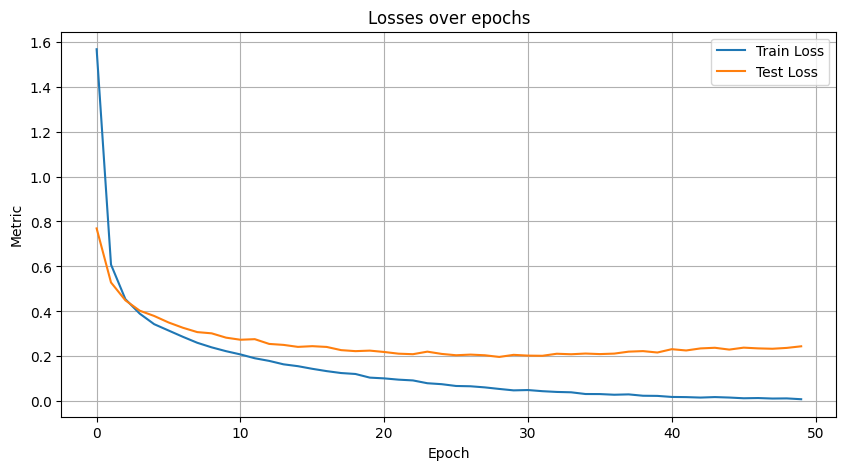

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 1 	Training Loss: 1.132414 	Validation Loss: 0.532213
Validation loss decreased (inf --> 0.532213).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 2 	Training Loss: 0.444290 	Validation Loss: 0.400612
Validation loss decreased (0.532213 --> 0.400612).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 3 	Training Loss: 0.357881 	Validation Loss: 0.341174
Validation loss decreased (0.400612 --> 0.341174).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 4 	Training Loss: 0.303052 	Validation Loss: 0.302426
Validation loss decreased (0.341174 --> 0.302426).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 5 	Training Loss: 0.265716 	Validation Loss: 0.261783
Validation loss decreased (0.302426 --> 0.261783).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 6 	Training Loss: 0.231649 	Validation Loss: 0.239912
Validation loss decreased (0.261783 --> 0.239912).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 7 	Training Loss: 0.202298 	Validation Loss: 0.223325
Validation loss decreased (0.239912 --> 0.223325).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 8 	Training Loss: 0.182305 	Validation Loss: 0.211658
Validation loss decreased (0.223325 --> 0.211658).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 9 	Training Loss: 0.161625 	Validation Loss: 0.187548
Validation loss decreased (0.211658 --> 0.187548).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 10 	Training Loss: 0.142005 	Validation Loss: 0.186087
Validation loss decreased (0.187548 --> 0.186087).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 11 	Training Loss: 0.134257 	Validation Loss: 0.181342
Validation loss decreased (0.186087 --> 0.181342).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 12 	Training Loss: 0.121652 	Validation Loss: 0.167711
Validation loss decreased (0.181342 --> 0.167711).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 13 	Training Loss: 0.109379 	Validation Loss: 0.159098
Validation loss decreased (0.167711 --> 0.159098).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 14 	Training Loss: 0.101068 	Validation Loss: 0.152403
Validation loss decreased (0.159098 --> 0.152403).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 15 	Training Loss: 0.090733 	Validation Loss: 0.151858
Validation loss decreased (0.152403 --> 0.151858).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 16 	Training Loss: 0.078865 	Validation Loss: 0.147836
Validation loss decreased (0.151858 --> 0.147836).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 17 	Training Loss: 0.073991 	Validation Loss: 0.149600


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 18 	Training Loss: 0.071469 	Validation Loss: 0.145818
Validation loss decreased (0.147836 --> 0.145818).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 19 	Training Loss: 0.063581 	Validation Loss: 0.141591
Validation loss decreased (0.145818 --> 0.141591).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 20 	Training Loss: 0.057185 	Validation Loss: 0.140996
Validation loss decreased (0.141591 --> 0.140996).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 21 	Training Loss: 0.052911 	Validation Loss: 0.139423
Validation loss decreased (0.140996 --> 0.139423).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 22 	Training Loss: 0.049217 	Validation Loss: 0.140731


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 23 	Training Loss: 0.042669 	Validation Loss: 0.135990
Validation loss decreased (0.139423 --> 0.135990).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 24 	Training Loss: 0.040565 	Validation Loss: 0.139441


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 25 	Training Loss: 0.034396 	Validation Loss: 0.146855


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 26 	Training Loss: 0.031812 	Validation Loss: 0.138750


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 27 	Training Loss: 0.031273 	Validation Loss: 0.142982


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 28 	Training Loss: 0.028065 	Validation Loss: 0.136270


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 29 	Training Loss: 0.025185 	Validation Loss: 0.142310


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 30 	Training Loss: 0.022887 	Validation Loss: 0.146797


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 31 	Training Loss: 0.018963 	Validation Loss: 0.149299


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 32 	Training Loss: 0.019766 	Validation Loss: 0.151902


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 33 	Training Loss: 0.018569 	Validation Loss: 0.144757


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 34 	Training Loss: 0.016037 	Validation Loss: 0.157640


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 35 	Training Loss: 0.015709 	Validation Loss: 0.153099


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 36 	Training Loss: 0.014584 	Validation Loss: 0.156474


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 37 	Training Loss: 0.011509 	Validation Loss: 0.156265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 38 	Training Loss: 0.012445 	Validation Loss: 0.157390


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 39 	Training Loss: 0.011917 	Validation Loss: 0.155904


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 40 	Training Loss: 0.010114 	Validation Loss: 0.160335


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 41 	Training Loss: 0.010535 	Validation Loss: 0.160950


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 42 	Training Loss: 0.011233 	Validation Loss: 0.168315


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 43 	Training Loss: 0.009016 	Validation Loss: 0.159880


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 44 	Training Loss: 0.006985 	Validation Loss: 0.172822


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 45 	Training Loss: 0.007719 	Validation Loss: 0.167200


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 46 	Training Loss: 0.008324 	Validation Loss: 0.176103


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 47 	Training Loss: 0.006845 	Validation Loss: 0.173060


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 48 	Training Loss: 0.007830 	Validation Loss: 0.174915


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 49 	Training Loss: 0.007655 	Validation Loss: 0.171864


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 50 	Training Loss: 0.006136 	Validation Loss: 0.175479


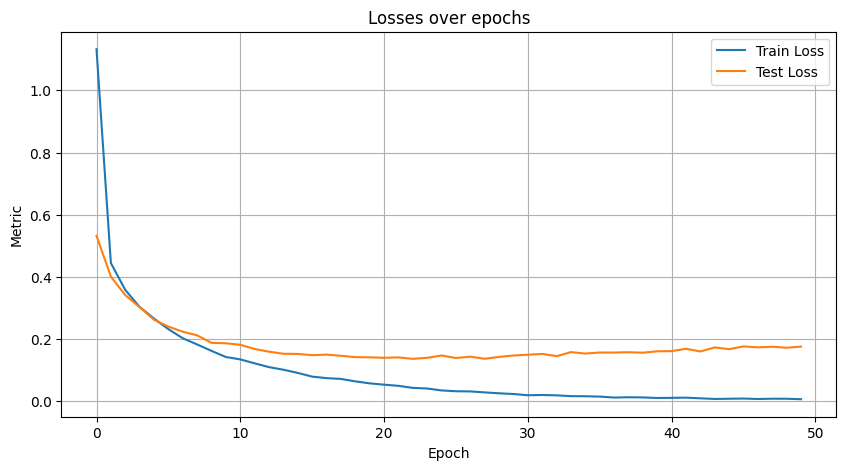

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 1 	Training Loss: 0.914949 	Validation Loss: 0.451737
Validation loss decreased (inf --> 0.451737).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 2 	Training Loss: 0.390381 	Validation Loss: 0.352148
Validation loss decreased (0.451737 --> 0.352148).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 3 	Training Loss: 0.304187 	Validation Loss: 0.286983
Validation loss decreased (0.352148 --> 0.286983).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 4 	Training Loss: 0.252155 	Validation Loss: 0.242778
Validation loss decreased (0.286983 --> 0.242778).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 5 	Training Loss: 0.209825 	Validation Loss: 0.211090
Validation loss decreased (0.242778 --> 0.211090).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 6 	Training Loss: 0.176316 	Validation Loss: 0.191781
Validation loss decreased (0.211090 --> 0.191781).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 7 	Training Loss: 0.155130 	Validation Loss: 0.185362
Validation loss decreased (0.191781 --> 0.185362).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 8 	Training Loss: 0.136699 	Validation Loss: 0.164515
Validation loss decreased (0.185362 --> 0.164515).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 9 	Training Loss: 0.122309 	Validation Loss: 0.152531
Validation loss decreased (0.164515 --> 0.152531).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 10 	Training Loss: 0.107306 	Validation Loss: 0.140557
Validation loss decreased (0.152531 --> 0.140557).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 11 	Training Loss: 0.095354 	Validation Loss: 0.139926
Validation loss decreased (0.140557 --> 0.139926).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 12 	Training Loss: 0.090145 	Validation Loss: 0.132263
Validation loss decreased (0.139926 --> 0.132263).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 13 	Training Loss: 0.078070 	Validation Loss: 0.130859
Validation loss decreased (0.132263 --> 0.130859).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 14 	Training Loss: 0.071565 	Validation Loss: 0.124925
Validation loss decreased (0.130859 --> 0.124925).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 15 	Training Loss: 0.063141 	Validation Loss: 0.127609


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 16 	Training Loss: 0.057479 	Validation Loss: 0.116206
Validation loss decreased (0.124925 --> 0.116206).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 17 	Training Loss: 0.051890 	Validation Loss: 0.118878


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 18 	Training Loss: 0.047759 	Validation Loss: 0.115208
Validation loss decreased (0.116206 --> 0.115208).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 19 	Training Loss: 0.043440 	Validation Loss: 0.119064


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 20 	Training Loss: 0.040229 	Validation Loss: 0.116655


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 21 	Training Loss: 0.035346 	Validation Loss: 0.112406
Validation loss decreased (0.115208 --> 0.112406).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 22 	Training Loss: 0.031759 	Validation Loss: 0.116809


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 23 	Training Loss: 0.029904 	Validation Loss: 0.115899


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 24 	Training Loss: 0.028508 	Validation Loss: 0.119466


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 25 	Training Loss: 0.026441 	Validation Loss: 0.127124


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 26 	Training Loss: 0.022986 	Validation Loss: 0.123946


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 27 	Training Loss: 0.021791 	Validation Loss: 0.124575


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 28 	Training Loss: 0.018096 	Validation Loss: 0.124750


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 29 	Training Loss: 0.018609 	Validation Loss: 0.127513


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 30 	Training Loss: 0.016000 	Validation Loss: 0.136498


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 31 	Training Loss: 0.015260 	Validation Loss: 0.130411


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 32 	Training Loss: 0.013713 	Validation Loss: 0.134991


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 33 	Training Loss: 0.012555 	Validation Loss: 0.131739


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 34 	Training Loss: 0.011428 	Validation Loss: 0.138456


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 35 	Training Loss: 0.012086 	Validation Loss: 0.136614


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 36 	Training Loss: 0.009726 	Validation Loss: 0.136704


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 37 	Training Loss: 0.010583 	Validation Loss: 0.139040


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 38 	Training Loss: 0.010001 	Validation Loss: 0.145916


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 39 	Training Loss: 0.009826 	Validation Loss: 0.143632


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 40 	Training Loss: 0.009238 	Validation Loss: 0.150629


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 41 	Training Loss: 0.008010 	Validation Loss: 0.162134


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 42 	Training Loss: 0.007502 	Validation Loss: 0.151692


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 43 	Training Loss: 0.007672 	Validation Loss: 0.156030


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 44 	Training Loss: 0.007246 	Validation Loss: 0.145456


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 45 	Training Loss: 0.007501 	Validation Loss: 0.153569


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 46 	Training Loss: 0.007037 	Validation Loss: 0.148401


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 47 	Training Loss: 0.005237 	Validation Loss: 0.156400


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 48 	Training Loss: 0.005286 	Validation Loss: 0.159691


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 49 	Training Loss: 0.005905 	Validation Loss: 0.166441


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 50 	Training Loss: 0.006329 	Validation Loss: 0.153675


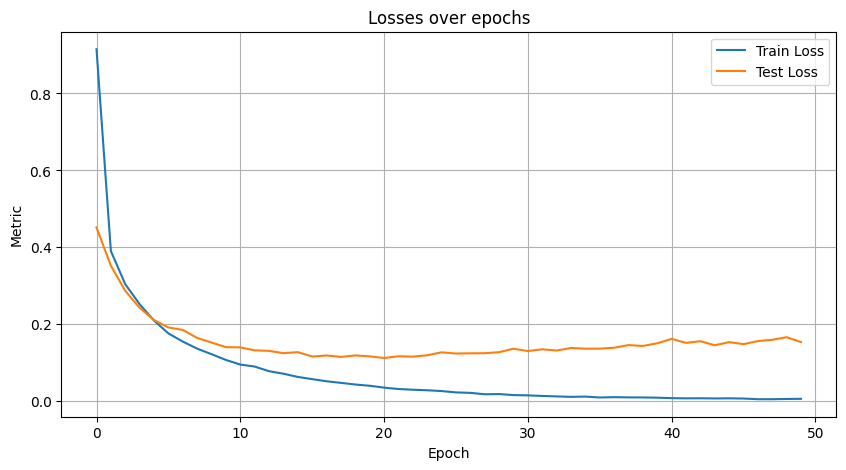

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 1 	Training Loss: 0.805256 	Validation Loss: 0.368442
Validation loss decreased (inf --> 0.368442).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 2 	Training Loss: 0.342639 	Validation Loss: 0.275059
Validation loss decreased (0.368442 --> 0.275059).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 3 	Training Loss: 0.258987 	Validation Loss: 0.222300
Validation loss decreased (0.275059 --> 0.222300).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 4 	Training Loss: 0.207333 	Validation Loss: 0.185041
Validation loss decreased (0.222300 --> 0.185041).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 5 	Training Loss: 0.172243 	Validation Loss: 0.164277
Validation loss decreased (0.185041 --> 0.164277).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 6 	Training Loss: 0.148650 	Validation Loss: 0.148379
Validation loss decreased (0.164277 --> 0.148379).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 7 	Training Loss: 0.128791 	Validation Loss: 0.133025
Validation loss decreased (0.148379 --> 0.133025).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 8 	Training Loss: 0.111336 	Validation Loss: 0.121709
Validation loss decreased (0.133025 --> 0.121709).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 9 	Training Loss: 0.097704 	Validation Loss: 0.117940
Validation loss decreased (0.121709 --> 0.117940).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 10 	Training Loss: 0.088874 	Validation Loss: 0.110864
Validation loss decreased (0.117940 --> 0.110864).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 11 	Training Loss: 0.078622 	Validation Loss: 0.108352
Validation loss decreased (0.110864 --> 0.108352).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 12 	Training Loss: 0.070800 	Validation Loss: 0.102233
Validation loss decreased (0.108352 --> 0.102233).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 13 	Training Loss: 0.062607 	Validation Loss: 0.101444
Validation loss decreased (0.102233 --> 0.101444).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 14 	Training Loss: 0.057265 	Validation Loss: 0.100301
Validation loss decreased (0.101444 --> 0.100301).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 15 	Training Loss: 0.051307 	Validation Loss: 0.094070
Validation loss decreased (0.100301 --> 0.094070).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 16 	Training Loss: 0.046526 	Validation Loss: 0.099927


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 17 	Training Loss: 0.043038 	Validation Loss: 0.092464
Validation loss decreased (0.094070 --> 0.092464).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 18 	Training Loss: 0.038565 	Validation Loss: 0.095047


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 19 	Training Loss: 0.034461 	Validation Loss: 0.093538


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 20 	Training Loss: 0.031870 	Validation Loss: 0.096289


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 21 	Training Loss: 0.028583 	Validation Loss: 0.092445
Validation loss decreased (0.092464 --> 0.092445).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 22 	Training Loss: 0.027278 	Validation Loss: 0.095980


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 23 	Training Loss: 0.025167 	Validation Loss: 0.096657


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 24 	Training Loss: 0.022760 	Validation Loss: 0.093330


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 25 	Training Loss: 0.022590 	Validation Loss: 0.095777


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 26 	Training Loss: 0.019396 	Validation Loss: 0.094934


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 27 	Training Loss: 0.016722 	Validation Loss: 0.096411


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 28 	Training Loss: 0.015933 	Validation Loss: 0.090460
Validation loss decreased (0.092445 --> 0.090460).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 29 	Training Loss: 0.016833 	Validation Loss: 0.095779


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 30 	Training Loss: 0.013688 	Validation Loss: 0.095719


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 31 	Training Loss: 0.013274 	Validation Loss: 0.097904


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 32 	Training Loss: 0.013479 	Validation Loss: 0.102259


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 33 	Training Loss: 0.012057 	Validation Loss: 0.104508


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 34 	Training Loss: 0.009902 	Validation Loss: 0.105270


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 35 	Training Loss: 0.011383 	Validation Loss: 0.106011


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 36 	Training Loss: 0.010100 	Validation Loss: 0.107182


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 37 	Training Loss: 0.009028 	Validation Loss: 0.110157


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 38 	Training Loss: 0.009760 	Validation Loss: 0.112897


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 39 	Training Loss: 0.008299 	Validation Loss: 0.118056


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 40 	Training Loss: 0.006761 	Validation Loss: 0.117777


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 41 	Training Loss: 0.007912 	Validation Loss: 0.117295


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 42 	Training Loss: 0.007588 	Validation Loss: 0.121668


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 43 	Training Loss: 0.006796 	Validation Loss: 0.124667


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 44 	Training Loss: 0.006044 	Validation Loss: 0.126283


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 45 	Training Loss: 0.006773 	Validation Loss: 0.123430


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 46 	Training Loss: 0.006744 	Validation Loss: 0.124447


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 47 	Training Loss: 0.005119 	Validation Loss: 0.118097


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 48 	Training Loss: 0.005350 	Validation Loss: 0.124712


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 49 	Training Loss: 0.005633 	Validation Loss: 0.128093


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 50 	Training Loss: 0.005379 	Validation Loss: 0.138875


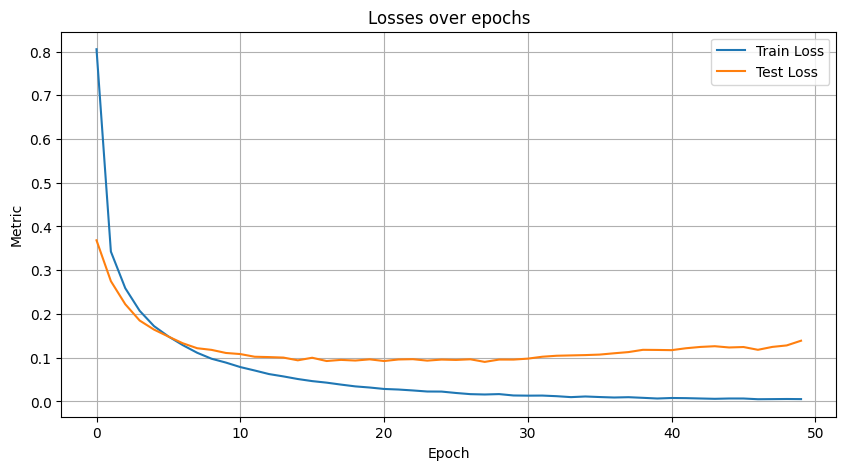

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 1 	Training Loss: 0.708614 	Validation Loss: 0.319178
Validation loss decreased (inf --> 0.319178).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 2 	Training Loss: 0.310467 	Validation Loss: 0.228683
Validation loss decreased (0.319178 --> 0.228683).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 3 	Training Loss: 0.230648 	Validation Loss: 0.173993
Validation loss decreased (0.228683 --> 0.173993).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 4 	Training Loss: 0.181353 	Validation Loss: 0.144827
Validation loss decreased (0.173993 --> 0.144827).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 5 	Training Loss: 0.149143 	Validation Loss: 0.124696
Validation loss decreased (0.144827 --> 0.124696).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 6 	Training Loss: 0.124994 	Validation Loss: 0.110083
Validation loss decreased (0.124696 --> 0.110083).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 7 	Training Loss: 0.111374 	Validation Loss: 0.100988
Validation loss decreased (0.110083 --> 0.100988).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 8 	Training Loss: 0.095781 	Validation Loss: 0.095908
Validation loss decreased (0.100988 --> 0.095908).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 9 	Training Loss: 0.086091 	Validation Loss: 0.090349
Validation loss decreased (0.095908 --> 0.090349).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 10 	Training Loss: 0.076478 	Validation Loss: 0.085485
Validation loss decreased (0.090349 --> 0.085485).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 11 	Training Loss: 0.067102 	Validation Loss: 0.084498
Validation loss decreased (0.085485 --> 0.084498).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 12 	Training Loss: 0.060587 	Validation Loss: 0.076936
Validation loss decreased (0.084498 --> 0.076936).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 13 	Training Loss: 0.055578 	Validation Loss: 0.075999
Validation loss decreased (0.076936 --> 0.075999).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 14 	Training Loss: 0.050976 	Validation Loss: 0.077202


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 15 	Training Loss: 0.043407 	Validation Loss: 0.075035
Validation loss decreased (0.075999 --> 0.075035).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 16 	Training Loss: 0.041582 	Validation Loss: 0.069677
Validation loss decreased (0.075035 --> 0.069677).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 17 	Training Loss: 0.037391 	Validation Loss: 0.071187


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 18 	Training Loss: 0.035009 	Validation Loss: 0.070882


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 19 	Training Loss: 0.029820 	Validation Loss: 0.078322


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 20 	Training Loss: 0.026725 	Validation Loss: 0.076611


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 21 	Training Loss: 0.026920 	Validation Loss: 0.071843


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 22 	Training Loss: 0.022746 	Validation Loss: 0.078591


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 23 	Training Loss: 0.022580 	Validation Loss: 0.076610


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 24 	Training Loss: 0.019806 	Validation Loss: 0.078834


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 25 	Training Loss: 0.019601 	Validation Loss: 0.078366


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 26 	Training Loss: 0.017233 	Validation Loss: 0.081558


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 27 	Training Loss: 0.015977 	Validation Loss: 0.081525


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 28 	Training Loss: 0.015350 	Validation Loss: 0.086379


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 29 	Training Loss: 0.013211 	Validation Loss: 0.077550


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 30 	Training Loss: 0.011941 	Validation Loss: 0.087220


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 31 	Training Loss: 0.012985 	Validation Loss: 0.084132


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 32 	Training Loss: 0.012039 	Validation Loss: 0.082278


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 33 	Training Loss: 0.011110 	Validation Loss: 0.083660


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 34 	Training Loss: 0.011070 	Validation Loss: 0.087259


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 35 	Training Loss: 0.010475 	Validation Loss: 0.085907


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 36 	Training Loss: 0.009173 	Validation Loss: 0.087449


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 37 	Training Loss: 0.009879 	Validation Loss: 0.093282


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 38 	Training Loss: 0.008070 	Validation Loss: 0.087060


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 39 	Training Loss: 0.007751 	Validation Loss: 0.091588


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 40 	Training Loss: 0.007844 	Validation Loss: 0.092731


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 41 	Training Loss: 0.006436 	Validation Loss: 0.098156


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 42 	Training Loss: 0.007448 	Validation Loss: 0.090622


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 43 	Training Loss: 0.006825 	Validation Loss: 0.093227


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 44 	Training Loss: 0.005399 	Validation Loss: 0.101091


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 45 	Training Loss: 0.006078 	Validation Loss: 0.105851


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 46 	Training Loss: 0.006336 	Validation Loss: 0.105199


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 47 	Training Loss: 0.006677 	Validation Loss: 0.101443


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 48 	Training Loss: 0.005424 	Validation Loss: 0.102255


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 49 	Training Loss: 0.005655 	Validation Loss: 0.098952


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 50 	Training Loss: 0.005801 	Validation Loss: 0.104306


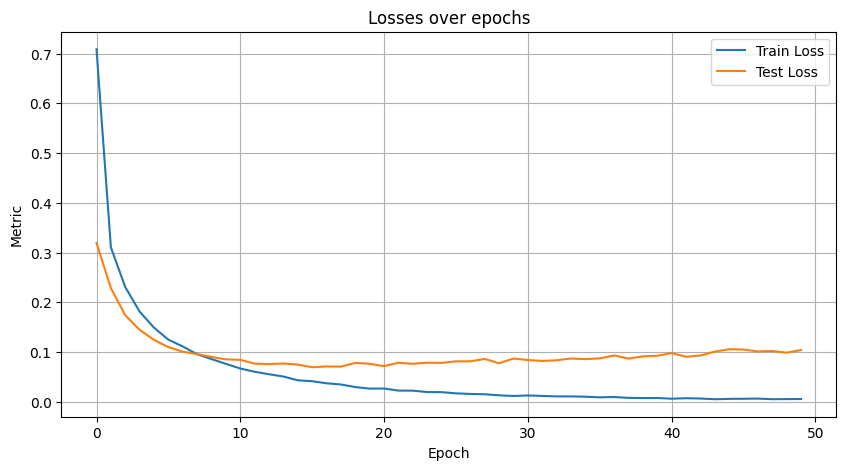

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 1 	Training Loss: 0.653048 	Validation Loss: 0.277201
Validation loss decreased (inf --> 0.277201).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 2 	Training Loss: 0.276351 	Validation Loss: 0.196784
Validation loss decreased (0.277201 --> 0.196784).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 3 	Training Loss: 0.203688 	Validation Loss: 0.145387
Validation loss decreased (0.196784 --> 0.145387).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 4 	Training Loss: 0.159389 	Validation Loss: 0.122121
Validation loss decreased (0.145387 --> 0.122121).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 5 	Training Loss: 0.130324 	Validation Loss: 0.104236
Validation loss decreased (0.122121 --> 0.104236).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 6 	Training Loss: 0.112051 	Validation Loss: 0.095002
Validation loss decreased (0.104236 --> 0.095002).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 7 	Training Loss: 0.097163 	Validation Loss: 0.085515
Validation loss decreased (0.095002 --> 0.085515).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 8 	Training Loss: 0.084327 	Validation Loss: 0.078197
Validation loss decreased (0.085515 --> 0.078197).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 9 	Training Loss: 0.073866 	Validation Loss: 0.074701
Validation loss decreased (0.078197 --> 0.074701).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 10 	Training Loss: 0.065950 	Validation Loss: 0.075305


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 11 	Training Loss: 0.059555 	Validation Loss: 0.067969
Validation loss decreased (0.074701 --> 0.067969).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 12 	Training Loss: 0.052117 	Validation Loss: 0.065701
Validation loss decreased (0.067969 --> 0.065701).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 13 	Training Loss: 0.047108 	Validation Loss: 0.065255
Validation loss decreased (0.065701 --> 0.065255).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 14 	Training Loss: 0.042977 	Validation Loss: 0.066303


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 15 	Training Loss: 0.038780 	Validation Loss: 0.061869
Validation loss decreased (0.065255 --> 0.061869).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 16 	Training Loss: 0.034483 	Validation Loss: 0.062646


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 17 	Training Loss: 0.031918 	Validation Loss: 0.060548
Validation loss decreased (0.061869 --> 0.060548).  Saving model ...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 18 	Training Loss: 0.028457 	Validation Loss: 0.060722


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 19 	Training Loss: 0.025495 	Validation Loss: 0.063029


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 20 	Training Loss: 0.024122 	Validation Loss: 0.063824


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 21 	Training Loss: 0.022381 	Validation Loss: 0.066960


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 22 	Training Loss: 0.020923 	Validation Loss: 0.066478


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 23 	Training Loss: 0.018577 	Validation Loss: 0.066277


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 24 	Training Loss: 0.018187 	Validation Loss: 0.064139


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 25 	Training Loss: 0.016644 	Validation Loss: 0.066115


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 26 	Training Loss: 0.015390 	Validation Loss: 0.063039


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 27 	Training Loss: 0.014446 	Validation Loss: 0.068606


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 28 	Training Loss: 0.013736 	Validation Loss: 0.071146


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 29 	Training Loss: 0.012108 	Validation Loss: 0.070027


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 30 	Training Loss: 0.012019 	Validation Loss: 0.077026


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 31 	Training Loss: 0.010615 	Validation Loss: 0.074470


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 32 	Training Loss: 0.010991 	Validation Loss: 0.069201


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 33 	Training Loss: 0.010237 	Validation Loss: 0.069894


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 34 	Training Loss: 0.009075 	Validation Loss: 0.076335


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 35 	Training Loss: 0.009699 	Validation Loss: 0.070702


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 36 	Training Loss: 0.007761 	Validation Loss: 0.077320


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 37 	Training Loss: 0.008381 	Validation Loss: 0.075230


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 38 	Training Loss: 0.007433 	Validation Loss: 0.079884


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 39 	Training Loss: 0.008320 	Validation Loss: 0.076618


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 40 	Training Loss: 0.007538 	Validation Loss: 0.081504


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 41 	Training Loss: 0.006962 	Validation Loss: 0.084486


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 42 	Training Loss: 0.006735 	Validation Loss: 0.085991


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 43 	Training Loss: 0.006132 	Validation Loss: 0.075297


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 44 	Training Loss: 0.005348 	Validation Loss: 0.078477


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 45 	Training Loss: 0.007001 	Validation Loss: 0.081631


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 46 	Training Loss: 0.005975 	Validation Loss: 0.088251


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 47 	Training Loss: 0.006145 	Validation Loss: 0.090571


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 48 	Training Loss: 0.006015 	Validation Loss: 0.088799


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 49 	Training Loss: 0.005495 	Validation Loss: 0.085434


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: Future

Epoch: 50 	Training Loss: 0.005580 	Validation Loss: 0.088201


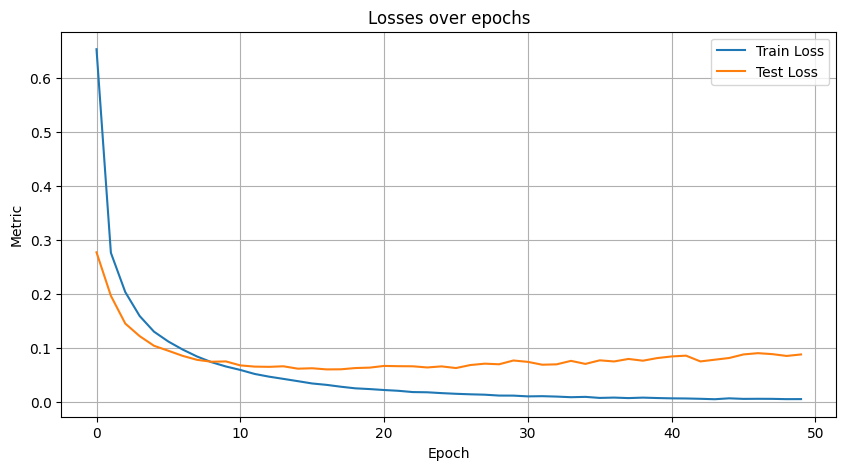

In [6]:
# Define a folder to store the output data
out_folder = 'exp_3'

# Create list with all batch sizes
batches = [1000, 2000, 3000, 4000, 5000, 10000, 20000, 30000, 40000, 50000, 60000]

# Create a cycle to train the model with all data batches
for batch in batches:
    # Define the base directory
    base_dir = f'./mnist_output/{out_folder}/weights_graphs_mlp_DataAmount{batch}/'

    # Perform training with defined batch of data
    fig, model_weights = batch_training(batch_size=batch, out_folder=out_folder)

    # Save the results
    torch.save(model_weights, f'{base_dir}weights_mlp_DataAmount{batch}.pth')
    fig.savefig(f'{base_dir}loss_mlp_DataAmount{batch}.png', dpi=300, bbox_inches='tight')

In [5]:
# Define our model for evaluation and calculating classification metrics
trained_model = MultiLayerPerceptron(28*28, 10)

# Load model's weights and turning evaluation mode
state_dict = torch.load("best_mlp_mnist_5layers.pt", map_location=torch.device("cpu"))
trained_model.load_state_dict(state_dict)
trained_model.eval()

# Convert images to tensors
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize( (0.1307, ), (0.3081, ))])

# Load test data
test_set = datasets.MNIST(root='data', train=False, download=True, transform=transform)

# Create DataLoader
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

y_true = []
y_pred = []

# Turn off gradient calculcation
with torch.no_grad():
    for images, labels in test_loader:
        outputs = trained_model(images)  # Get the image through the network
        _, predicted = torch.max(outputs, 1)  # Obtain predicted labels

        y_true.extend(labels.numpy())  # Real labels
        y_pred.extend(predicted.numpy())  # Predicted labels

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average="weighted")
recall = recall_score(y_true, y_pred, average="weighted")
f1 = f1_score(y_true, y_pred, average="weighted")

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print("\nClassification Report:\n", classification_report(y_true, y_pred))

/var/folders/nd/fsmv2lz93k3_cjwz_1lx75j80000gn/T/ipykernel_72112/658819068.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("best_mlp_mnist_5layer

Accuracy: 0.9832
Precision: 0.9832
Recall: 0.9832
F1-score: 0.9832

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.98      0.99      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.98      0.98      0.98       892
           6       0.99      0.98      0.98       958
           7       0.99      0.98      0.98      1028
           8       0.98      0.98      0.98       974
           9       0.98      0.98      0.98      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



In [ ]:
save_model_metrics_to_json(json_path='./mnist_output/metrics.json', model_name='best_model', accuracy=accuracy, precision=precision, recall=recall, f1_score=f1)